All needed imports are done

In [22]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from keras import layers
from keras.applications.vgg16 import VGG16

from keras.models import Sequential
from keras.layers import Dense, Flatten, GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model

TODO

In [24]:
# Charge model VGC16 with imagenet weights
model_vgc = VGG16(weights='imagenet', include_top=False, input_shape=(224, 150, 3))
for(layer) in model_vgc.layers:
    layer.trainable = False

x = model_vgc.output
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dense(52, activation='softmax')(x)  

model = Model(inputs=model_vgc.input, outputs=x)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 75, 64)       0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 75, 128)      73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 75, 128)      147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 37, 128)       0   

TODO

In [25]:
folder = 'images/training/labeled/'
from keras.applications.vgg16 import preprocess_input

# Data generator
datagen = ImageDataGenerator(preprocessing_function=preprocess_input, horizontal_flip=True, validation_split=0.2)
train_generator = datagen.flow_from_directory(folder, target_size=(224, 150), batch_size=52, class_mode='categorical', subset='training')
test_generator = datagen.flow_from_directory(folder, target_size=(224, 150), batch_size=52, class_mode='categorical', subset='validation')

Found 2080 images belonging to 52 classes.
Found 520 images belonging to 52 classes.


TODO

In [26]:
history = model.fit(train_generator, epochs=20, validation_data=test_generator)
model.save('model_fulldeck.h5')
np.save('history.npy',history.history)

Epoch 1/20
40/40 [==============================] - 9s 207ms/step - loss: 6.6908 - accuracy: 0.6313 - val_loss: 0.4088 - val_accuracy: 0.8846
Epoch 2/20
40/40 [==============================] - 7s 181ms/step - loss: 0.1798 - accuracy: 0.9433 - val_loss: 0.1777 - val_accuracy: 0.9500
Epoch 3/20
40/40 [==============================] - 7s 178ms/step - loss: 0.0340 - accuracy: 0.9889 - val_loss: 0.0809 - val_accuracy: 0.9788
Epoch 4/20
40/40 [==============================] - 7s 178ms/step - loss: 0.0209 - accuracy: 0.9933 - val_loss: 0.0836 - val_accuracy: 0.9788
Epoch 5/20
40/40 [==============================] - 7s 178ms/step - loss: 0.0276 - accuracy: 0.9933 - val_loss: 0.0793 - val_accuracy: 0.9827
Epoch 6/20
40/40 [==============================] - 8s 187ms/step - loss: 0.0266 - accuracy: 0.9947 - val_loss: 0.2486 - val_accuracy: 0.9538
Epoch 7/20
40/40 [==============================] - 8s 189ms/step - loss: 0.0276 - accuracy: 0.9923 - val_loss: 0.1496 - val_accuracy: 0.9673
Epoch 

In [ ]:
def decode_predictions_custom(preds, top=3, class_list=None):
    if class_list is None:
        class_list = ['C10', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'CA', 'CJ', 'CK', 'CQ', 'D10', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9', 'DA', 'DJ', 'DK', 'DQ', 'H10', 'H2', 'H3', 'H4', 'H5', 'H6', 'H7', 'H8', 'H9', 'HA', 'HJ', 'HK', 'HQ', 'S10', 'S2', 'S3', 'S4', 'S5', 'S6', 'S7', 'S8', 'S9', 'SA', 'SJ', 'SK', 'SQ']
        
    results = []
    for pred in preds:
        top_indices = pred.argsort()[-top:][::-1]
        result = [(class_list[i], pred[i]*100.0) for i in top_indices]
        results.append(result)
    return results

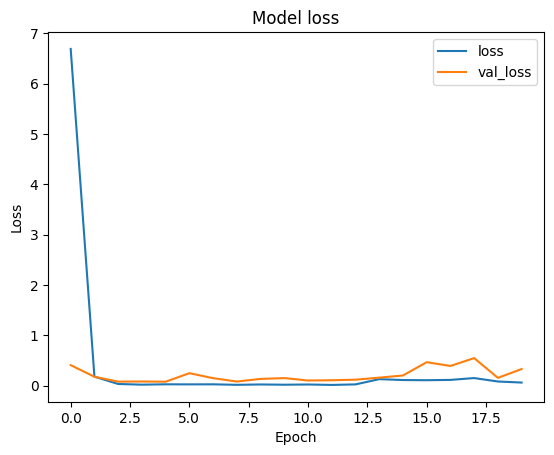

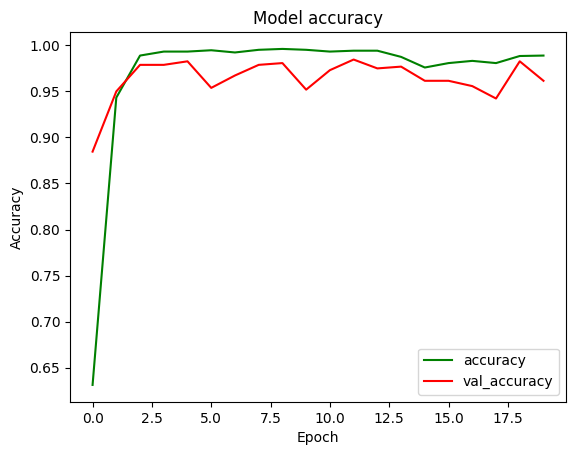

In [27]:
history=np.load('history.npy',allow_pickle=True).item()

# Plot the loss and val_loss
plt.figure(1)
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['loss', 'val_loss'], loc='upper right')

# Plot the accuracy and val_accuracy
plt.figure(2)
plt.plot(history['accuracy'], color='green')
plt.plot(history['val_accuracy'], color='red')
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['accuracy', 'val_accuracy'], loc='lower right')

# Show the plots
plt.show()


In [ ]:
import cv2
import numpy as np

from tensorflow.keras.preprocessing import image

model = keras.models.load_model('model_fulldeck.h5')

var = cv2.imread('Card 4.png')
var_resized = cv2.resize(var, (150, 224))

var_resized = image.img_to_array(var_resized)
var_resized = np.expand_dims(var_resized, axis=0)
var_resized = tf.keras.applications.imagenet_utils.preprocess_input(var_resized)
prediction = model.predict(var_resized)

decoded = decode_predictions_custom(prediction)
print(decoded)


ModuleNotFoundError: No module named 'cv2'